# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
import logging
import os
import sys
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import boto3
import io

from sklearn.preprocessing import MinMaxScaler
import sklearn.preprocessing
from sklearn.metrics.pairwise import cosine_similarity
import sklearn.metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import scipy
from implicit.als import AlternatingLeastSquares

In [2]:

from dotenv import load_dotenv

load_dotenv()

S3_BUCKET_NAME = os.getenv('S3_BUCKET_NAME')
AWS_ACCESS_KEY_ID = os.getenv('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = os.getenv('AWS_SECRET_ACCESS_KEY')
bucket_path = 'recsys/data/'

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [4]:
# !wget https://storage.yandexcloud.net/mle-data/ym/tracks.parquet

# !wget https://storage.yandexcloud.net/mle-data/ym/catalog_names.parquet

# !wget https://storage.yandexcloud.net/mle-data/ym/interactions.parquet

In [5]:
tracks = pd.read_parquet('tracks.parquet')
catalog_names = pd.read_parquet('catalog_names.parquet')
interactions = pd.read_parquet('interactions.parquet')


# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [6]:
tracks.head()

,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]
3,136,"[12, 214, 2490809]",[84],[11]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]


In [7]:
catalog_names.head()

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack


In [8]:
interactions.head()

,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21
3,0,590303,4,2022-07-22
4,0,590692,5,2022-07-22


In [9]:
print('Количество пропущенных значений в tracks:')
print(tracks.isna().sum())

print('\n\nКоличество пропущенных значений в catalog_names:')
print(catalog_names.isna().sum())

print('\n\nКоличество пропущенных значений в interactions:')
print(interactions.isna().sum())


Количество пропущенных значений в tracks:
track_id    0
albums      0
artists     0
genres      0
dtype: int64


Количество пропущенных значений в catalog_names:
id      0
type    0
name    0
dtype: int64


Количество пропущенных значений в interactions:
user_id       0
track_id      0
track_seq     0
started_at    0
dtype: int64


In [10]:
print('Типы данных в tracks:')
print(tracks.dtypes)

print('\n\nТипы данных в catalog_names:')
print(catalog_names.dtypes)

print('\n\nТипы данных в interactions:')
print(interactions.dtypes)

Типы данных в tracks:
track_id     int64
albums      object
artists     object
genres      object
dtype: object


Типы данных в catalog_names:
id       int64
type    object
name    object
dtype: object


Типы данных в interactions:
user_id                int32
track_id               int32
track_seq              int16
started_at    datetime64[ns]
dtype: object


In [11]:
print('Количество уникальных пользователей в interactions:')
print(interactions['user_id'].nunique())

print('Количество уникальных треков в interactions:')
print(interactions['track_id'].nunique())

print('\n\nКоличество уникальных треков в tracks:')
print(tracks['track_id'].nunique())

print('\n\nКоличество уникальных объектов в catalog_names:')
print(catalog_names['id'].nunique())

Количество уникальных пользователей в interactions:
1373221
Количество уникальных треков в interactions:
1000000


Количество уникальных треков в tracks:
1000000


Количество уникальных объектов в catalog_names:
1776697


In [12]:
print('Минимальная дата в interactions:')
print(interactions['started_at'].min())

print('\n\nМаксимальная дата в interactions:')
print(interactions['started_at'].max())

Минимальная дата в interactions:
2022-01-01 00:00:00


Максимальная дата в interactions:
2022-12-31 00:00:00


In [13]:
# проверка на наличие треков в interactions, которых нет в tracks
interactions[~interactions['track_id'].isin(tracks['track_id'].unique())]

,user_id,track_id,track_seq,started_at


In [14]:
all_albums = set(np.concatenate(tracks['albums'].tolist()))
albums_without_names = all_albums - set(catalog_names['id'].tolist())
print(albums_without_names)

set()


In [15]:
all_genres = set(np.concatenate(tracks['genres'].tolist()))
genres_without_names = all_genres - set(catalog_names['id'].tolist())
print(genres_without_names)

{160, 161, 130, 131, 164, 168, 169, 153, 155, 124, 159}


In [16]:
all_artists = set(np.concatenate(tracks['artists'].tolist()))
artists_without_names = all_artists - set(catalog_names['id'].tolist())
print(artists_without_names)

set()


In [17]:
all_tracks = set(tracks['track_id'].unique())
tracks_without_names = all_tracks - set(catalog_names['id'].tolist())
print(tracks_without_names)

set()


In [18]:
tracks_without_genres = tracks[tracks['genres'].apply(lambda x: any(genre in genres_without_names for genre in x))]['track_id'].unique()



In [19]:
interactions[interactions['track_id'].isin(tracks_without_genres)]['track_id'].shape[0] / interactions['track_id'].shape[0]

0.021482743526208686

In [20]:
len(tracks_without_genres)

18323

In [21]:
catalog_names['type'].value_counts(normalize=True)

type
track     0.551733
album     0.363440
artist    0.084736
genre     0.000092
Name: proportion, dtype: float64

In [22]:
catalog_names.head(5)

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack


In [23]:
genres_without_names_df = pd.DataFrame(genres_without_names, columns=['id'])
genres_without_names_df['type'] = 'genre'
genres_without_names_df['name'] = 'unknown genre'
catalog_names = pd.concat([genres_without_names_df, catalog_names], ignore_index=True)

In [24]:
default_album = 0
default_genre = 12345
default_artist = 1

tracks_albums = tracks[['track_id', 'albums']].explode('albums')
tracks_albums['albums'].fillna(default_album, inplace=True)
tracks_albums['albums'] = tracks_albums['albums'].astype(int)

tracks_genres = tracks[['track_id', 'genres']].explode('genres')
tracks_genres['genres'].fillna(default_genre, inplace=True)
tracks_genres['genres'] = tracks_genres['genres'].astype(int)

tracks_artists = tracks[['track_id', 'artists']].explode('artists')
tracks_artists['artists'].fillna(default_artist, inplace=True)
tracks_artists['artists'] = tracks_artists['artists'].astype(int)


print(tracks.shape)
print(tracks_albums.shape)
print(tracks_genres.shape)
print(tracks_artists.shape)

(1000000, 4)
(3128826, 2)
(1656345, 2)
(1279581, 2)


In [25]:
events = interactions.copy()

In [26]:
del interactions

# Выводы

Приведём выводы по первому знакомству с данными:
- В данных были выявлены две проблемы:  
    a) жанры некоторых треков без названия  
    b) id жанров, альбомов и артистов в виде списка, в котором могут быть пропуски и сложности просчета  
    c) атрибут started_at в неудобном формате numpy.datetime

- Были произведены следующие действия:  
    a) жанры без названия добавлены с название "unknown genre"  
    b) id жанров, альбомов и артистов представлены в виде отдельных таблиц с присвоением типа int каждому id  
    c) переводим started_at в тип pd.datetime

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

In [27]:
user_stats = events.groupby('track_id').agg(tracks_amt = ('user_id', 'nunique'))
print('Минимальное количество пользователей, прослушавших трек:', user_stats['tracks_amt'].min())
print('Максимальное количество пользователей, прослушавших трек:', user_stats['tracks_amt'].max())
print('Среднее количество пользователей, прослушавших трек:', user_stats['tracks_amt'].mean())
print('Медиана количества пользователей, прослушавших трек:', user_stats['tracks_amt'].median())
print('Квартиль 0.05 количества пользователей, прослушавших трек:', user_stats['tracks_amt'].quantile(0.05))
print('Квартиль 0.25 количества пользователей, прослушавших трек:', user_stats['tracks_amt'].quantile(0.25))
print('Квартиль 0.75 количества пользователей, прослушавших трек:', user_stats['tracks_amt'].quantile(0.75))
print('Квартиль 0.95 количества пользователей, прослушавших трек:', user_stats['tracks_amt'].quantile(0.95))

Минимальное количество пользователей, прослушавших трек: 5
Максимальное количество пользователей, прослушавших трек: 111062
Среднее количество пользователей, прослушавших трек: 222.629898
Медиана количества пользователей, прослушавших трек: 19.0
Квартиль 0.05 количества пользователей, прослушавших трек: 5.0
Квартиль 0.25 количества пользователей, прослушавших трек: 9.0
Квартиль 0.75 количества пользователей, прослушавших трек: 67.0
Квартиль 0.95 количества пользователей, прослушавших трек: 760.0


Распределение прослушанных треков во времени

In [28]:
plt.style.use('ggplot')

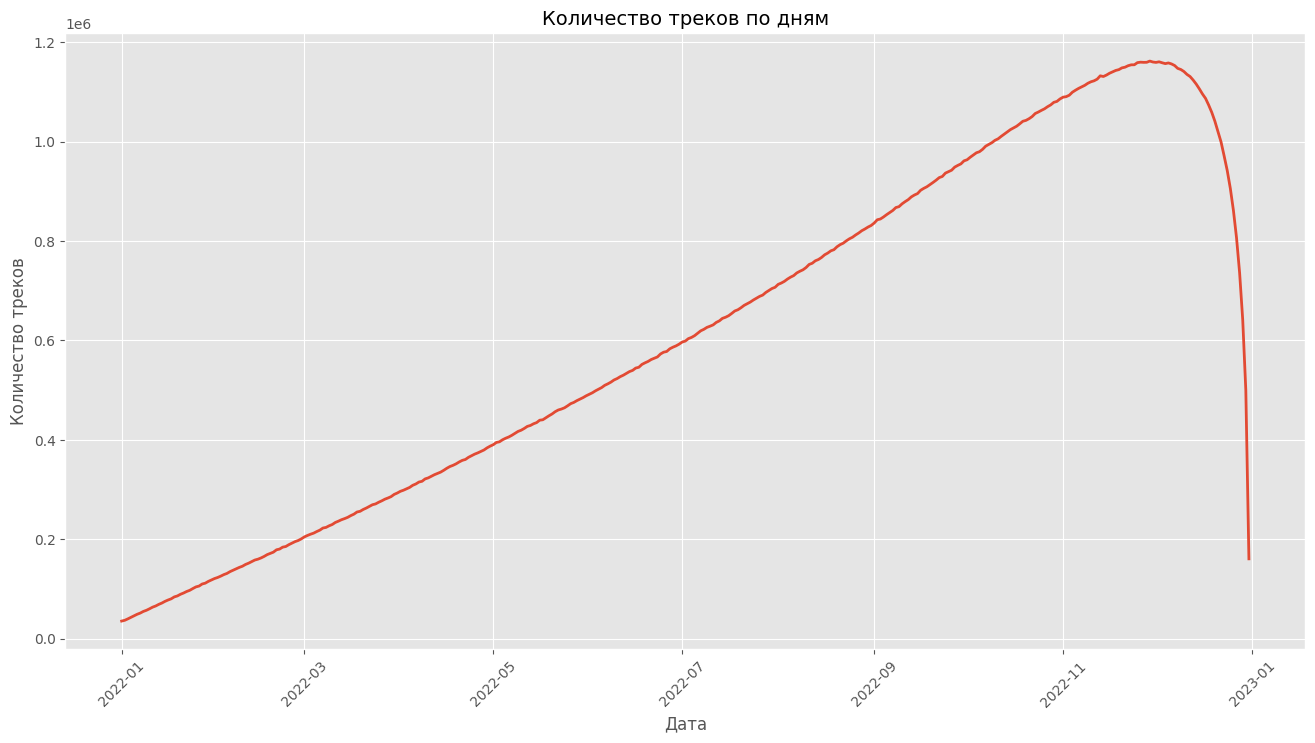

In [29]:
f, ax = plt.subplots(figsize=(16,8))

data_agg = events.groupby('started_at', as_index=False).agg({'track_id': 'count'}).sort_values('started_at', ascending=True)

plt.plot(data_agg['started_at'], data_agg['track_id'], linewidth=2)
ax.set_title('Количество треков по дням', fontsize=14)
ax.set_xlabel('Дата', fontsize=12)
ax.set_ylabel('Количество треков', fontsize=12)
ax.tick_params(axis='x', rotation=45)

plt.show()

Наиболее популярные треки

In [30]:
catalog_names.set_index('id', inplace=True)

In [31]:
print('Топ-10 популярных треков:\n')

for track_id in user_stats.sort_values(by='tracks_amt', ascending=False).head(10).index:
    print(catalog_names.loc[track_id, 'name'])

Топ-10 популярных треков:

Smells Like Teen Spirit
Believer
Numb
I Got Love
Юность
Way Down We Go
Shape of You
In The End
Shape Of My Heart
Life


Наиболее популярные жанры

In [32]:
genre_stats = user_stats.reset_index().merge(tracks_genres, on='track_id', how='left')
genre_stats = genre_stats.groupby('genres').agg(tracks_amt = ('tracks_amt', 'sum'))
genre_stats.sort_values(by='tracks_amt', ascending=False, inplace=True)

print('Наиболее популярные жанры:\n')
genre_names = catalog_names.query("type == 'genre'")

for genre_id in genre_stats.sort_values(by='tracks_amt', ascending=False).head(10).index:
    print(genre_names.loc[genre_id, 'name'])

Наиболее популярные жанры:

pop
rap
allrock
ruspop
rusrap
electronics
dance
rusrock
rock
metal


Треки, которые никто не прослушал

In [33]:
len(set(tracks['track_id']))

1000000

In [34]:
len(set(events['track_id']))

1000000

In [35]:
set(tracks['track_id']) - set(events['track_id'])

set()

Нет треков, которые не были прослушаны, таблица tracks включает только прослушанные треки

# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

In [36]:
events.head(5)

,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21
3,0,590303,4,2022-07-22
4,0,590692,5,2022-07-22


In [37]:
tracks.rename(columns={'track_id': 'item_id'}, inplace=True)
events.rename(columns={'track_id': 'item_id'}, inplace=True)



# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [38]:
import os
from dotenv import load_dotenv
import boto3
import s3fs
import io

load_dotenv()

S3_BUCKET_NAME = os.getenv('S3_BUCKET_NAME')
AWS_ACCESS_KEY_ID = os.getenv('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = os.getenv('AWS_SECRET_ACCESS_KEY')

bucket_path = 'recsys/data/'

In [22]:
s3 = boto3.client(
            "s3",
            endpoint_url='https://storage.yandexcloud.net',
            aws_access_key_id=AWS_ACCESS_KEY_ID,
            aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
        )


In [21]:
def upload_parquet_to_s3(bucket_name, key, data):
    
    parquet_buffer = io.BytesIO()
    data.to_parquet(parquet_buffer, allow_truncated_timestamps=True)

    parquet_buffer.seek(0)
    s3.put_object(Bucket=bucket_name, Key=bucket_path+key, Body=parquet_buffer.read())
    return True

In [41]:
upload_parquet_to_s3(S3_BUCKET_NAME, 'items.parquet', tracks)
upload_parquet_to_s3(S3_BUCKET_NAME, 'events.parquet', events)

True

# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

In [42]:
del tracks
del catalog_names

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [3]:
s3 = boto3.client(
            "s3",
            endpoint_url='https://storage.yandexcloud.net',
            aws_access_key_id=AWS_ACCESS_KEY_ID,
            aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
        )

In [4]:
def read_parquet_from_s3(bucket_name, key):
    
    parquet_buffer = io.BytesIO()
    s3_object = s3.get_object(Bucket=bucket_name, Key=bucket_path+key)
    parquet_buffer.write(s3_object["Body"].read())
    parquet_buffer.seek(0)

    data = pd.read_parquet(parquet_buffer)
    
    return data

In [5]:

items = read_parquet_from_s3(S3_BUCKET_NAME, 'items.parquet')
events = read_parquet_from_s3(S3_BUCKET_NAME, 'events.parquet')


# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [6]:
# зададим точку разбиения
train_test_global_time_split_date = np.quantile(events['started_at'], 0.8)

train_test_global_time_split_idx = events["started_at"] < train_test_global_time_split_date
events_train = events[train_test_global_time_split_idx]
events_test = events[~train_test_global_time_split_idx]

# количество пользователей в train и test
users_train = events_train["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates()
# количество пользователей, которые есть и в train, и в test
common_users = events_train[events_train["user_id"].isin(events_test["user_id"])]["user_id"].unique()

print(len(users_train), len(users_test), len(common_users)) 

1253503 1093486 973768


In [7]:
scaler = MinMaxScaler()
events_train['track_seq'] = scaler.fit_transform(events_train[['track_seq']])
events_test['track_seq'] = scaler.transform(events_test[['track_seq']])

events_train['track_seq'] = 1 - events_train['track_seq']
events_test['track_seq'] = 1 - events_test['track_seq']

/tmp/ipykernel_3412/1057732856.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_train['track_seq'] = scaler.fit_transform(events_train[['track_seq']])
/tmp/ipykernel_3412/1057732856.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_test['track_seq'] = scaler.transform(events_test[['track_seq']])
/tmp/ipykernel_3412/1057732856.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [ ]:
item_popularity = events_train \
    .groupby(["item_id"]).agg(users=("user_id", "nunique"), avg_seq=("track_seq", "mean")).reset_index()

# нормализация пользователей и среднего рейтинга, требуется для их приведения к одному масштабу
scaler = MinMaxScaler()
item_popularity[["users_norm", "avg_seq_norm"]] = scaler.fit_transform(
    item_popularity[["users", "avg_seq"]]
)

# вычисляем popularity_score, как скор популярности со штрафом за низкий рейтинг
item_popularity["popularity_score"] = (
    item_popularity["users_norm"] * (1-item_popularity["avg_seq_norm"])
)

# сортируем по убыванию popularity_score
item_popularity = item_popularity.sort_values(by="popularity_score", ascending=False)

# выбираем первые 100 айтемов со средней оценкой avg_rating не меньше 4
top_k_pop_items = item_popularity.head(100)

In [17]:
top_k_pop_items.to_parquet('data/top_k_pop_items.parquet')

# Персональные

Рассчитаем персональные рекомендации.

In [8]:
# перекодируем идентификаторы пользователей: 
# из имеющихся в последовательность 0, 1, 2, ...
user_encoder = sklearn.preprocessing.LabelEncoder()
user_encoder.fit(events["user_id"])
events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])

# перекодируем идентификаторы объектов: 
# из имеющихся в последовательность 0, 1, 2, ...
item_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder.fit(items["item_id"])
items["item_id_enc"] = item_encoder.transform(items["item_id"])
events_train["item_id_enc"] = item_encoder.transform(events_train["item_id"])
events_test["item_id_enc"] = item_encoder.transform(events_test["item_id"])

/tmp/ipykernel_3412/3293259747.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
/tmp/ipykernel_3412/3293259747.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])
/tmp/ipykernel_3412/3293259747.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [9]:
# создаём sparse-матрицу формата CSR 
user_item_matrix_train = scipy.sparse.csr_matrix((
    events_train["track_seq"],
    (events_train['user_id_enc'], events_train['item_id_enc'])),
    dtype=np.int8) 

In [10]:
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [11]:
als_model = AlternatingLeastSquares(factors=50, iterations=10, regularization=0.05, random_state=0)


/home/mle-user/.local/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


In [12]:
# если модель уже обучена, то загружаем ее из файла
if os.path.exists('als_model.pkl'):
    with open('als_model.pkl', 'rb') as f:
        als_model = pickle.load(f)
else:
    # если модель не обучена, то обучаем ее
    als_model.fit(user_item_matrix_train) 
    with open('als_model.pkl', 'wb') as f:
        pickle.dump(als_model, f)

In [13]:
def get_recommendations_als(user_item_matrix, model, user_id, user_encoder, item_encoder, include_seen=True, n=5):
    """
    Возвращает отранжированные рекомендации для заданного пользователя
    """
    user_id_enc = user_encoder.transform([user_id])[0]
    recommendations = model.recommend(
         user_id_enc, 
         user_item_matrix[user_id_enc], 
         filter_already_liked_items=not include_seen,
         N=n)
    recommendations = pd.DataFrame({"item_id_enc": recommendations[0], "score": recommendations[1]})
    recommendations["item_id"] = item_encoder.inverse_transform(recommendations["item_id_enc"])
    
    return recommendations 

In [14]:
n_events = 100000

# получаем рекомендации для всех пользователей
als_recommendations = als_model.recommend(
    events_test.head(n_events)["user_id_enc"].unique(), 
    user_item_matrix_train[events_test.head(n_events)["user_id_enc"].unique()], 
    filter_already_liked_items=False, N=100) 

In [17]:
len(als_recommendations[0])

2430

In [18]:
# преобразуем полученные рекомендации в табличный формат
item_ids_enc = als_recommendations[0]
als_scores = als_recommendations[1]

als_recommendations = pd.DataFrame({
    "user_id_enc": events_test.head(n_events)["user_id_enc"].unique(),
    "item_id_enc": item_ids_enc.tolist(), 
    "score": als_scores.tolist()})
als_recommendations = als_recommendations.explode(["item_id_enc", "score"], ignore_index=True)

# приводим типы данных
als_recommendations["item_id_enc"] = als_recommendations["item_id_enc"].astype("int")
als_recommendations["score"] = als_recommendations["score"].astype("float")

# получаем изначальные идентификаторы
als_recommendations["user_id"] = user_encoder.inverse_transform(als_recommendations["user_id_enc"])
als_recommendations["item_id"] = item_encoder.inverse_transform(als_recommendations["item_id_enc"])
als_recommendations = als_recommendations.drop(columns=["user_id_enc", "item_id_enc"])

In [19]:
als_recommendations = als_recommendations[["user_id", "item_id", "score"]]
als_recommendations.to_parquet("als_recommendations.parquet")

In [23]:
upload_parquet_to_s3(S3_BUCKET_NAME, 'als_recommendations.parquet', als_recommendations)

True

# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [24]:
als_similar_items = als_model.similar_items(events_test.head(n_events)["item_id_enc"].unique(), N=100)

In [25]:
# преобразуем полученные рекомендации в табличный формат
item_ids_enc = als_similar_items[0]
als_scores = als_similar_items[1]

als_similar = pd.DataFrame({
    "item_id_enc": events_test.head(n_events)["item_id_enc"].unique(),
    "similar_item_id_enc": item_ids_enc.tolist(), 
    "score": als_scores.tolist()})
als_similar = als_similar.explode(["similar_item_id_enc", "score"], ignore_index=True)

# приводим типы данных
als_similar["similar_item_id_enc"] = als_similar["similar_item_id_enc"].astype("int")
als_similar["score"] = als_similar["score"].astype("float")

# получаем изначальные идентификаторы
als_similar["item_id"] = item_encoder.inverse_transform(als_similar["item_id_enc"])
als_similar["similar_item_id"] = item_encoder.inverse_transform(als_similar["similar_item_id_enc"])
als_similar = als_similar.drop(columns=["similar_item_id_enc", "item_id_enc"])

In [26]:
als_similar.to_parquet("als_similar.parquet")

In [27]:
upload_parquet_to_s3(S3_BUCKET_NAME, "als_similar.parquet", als_similar)

True

# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.